In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep

In [2]:
# making the animation was taken from https://casey-barr.github.io/open-ai-taxi-problem/

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.2)
        
def smooth(data,window=10):
    smoothing_filter = np.ones(window)/window
    data_smooth = np.convolve(data, smoothing_filter, mode='same')
    return data_smooth

def plot_data(data_train,data_test, x_axis='x', y_axis='y', smoothing=False, window=10):
    
    if smoothing:
        data_train_plot = smooth(data_train, window=window)
    else:
        data_train_plot = data_train
        
    data_test_plot = data_test*np.ones(np.shape(data_train_plot))
    plt.figure(figsize=(12, 6))
    plt.plot(data_train_plot)
    plt.plot(data_test_plot,'r--')
    plt.xlabel(x_axis, fontsize=20)
    plt.ylabel(y_axis, fontsize=20)
    plt.legend(['Train','Test'], fontsize=16)
    plt.title('Q-learning on Taxi', fontsize=24)
    plt.grid()

In [3]:
# Define the AGENT - Q learning

class Agent():

    def __init__(self, env, policy=None, gamma=0.99, alpha=0.05, epsilon=0.2, decay_rate=0.01):
        
        self.env = env
        self.policy = policy # policy pi
        self.gamma = gamma   # discount rate
        self.alpha = alpha   # constant step-size
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.max_epsilon = 1.0
        self.min_epsilon = 0.01
        self.Q = np.zeros((env.observation_space.n, env.action_space.n))
        print(np.shape(self.Q))
        
    def train(self, N_episodes=1, max_steps=1e6):
        
        reward_per_episode = np.zeros(N_episodes)
        penalty_per_episode = np.zeros(N_episodes)
        steps_per_episode = np.zeros(N_episodes)
        
        for ii in range(N_episodes):
            
            s = self.env.reset() # reset initial state at every episode
            
            for step in range(max_steps):
                # policy pi_eps
                if np.random.rand() < self.epsilon:
                    a = self.env.action_space.sample() 
                else:
                    a = np.argmax(self.Q[s,:])
                    
                sp, r, done, _ = self.env.step(a)
                a_star = np.argmax(self.Q[sp,:])
                
                reward_per_episode[ii] += r
                if r == -10:
                    penalty_per_episode[ii] += 1
                
                # training line
                self.Q[s,a] += self.alpha * (r + self.gamma * (self.Q[sp,a_star] if not done else 0) - self.Q[s,a])
                s = sp
                if done:
                    steps_per_episode[ii] = step + 1
                    break
            
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-self.decay_rate*ii)
            
        return reward_per_episode, penalty_per_episode, steps_per_episode

In [4]:
# Define the ENVIRONMENT - TAXI-v3

env_name = "Taxi-v3"
env = gym.make(env_name)
state = env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
# print out all the actions

print("Number of actions: ", env.action_space.n)
print("Number of states: ", env.observation_space.n)
for ii in range (env.action_space.n):
    print("Action number {} performs this the following movement:".format(ii))
    # the movement is represented in the parentheses of the image
    env.step(ii)
    env.render()

Number of actions:  6
Number of states:  500
Action number 0 performs this the following movement:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
Action number 1 performs this the following movement:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
Action number 2 performs this the following movement:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
Action number 3 performs this the following movement:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
Action number 4 performs this the following movement:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
Action number 5 performs this the following movement:
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [6]:
N_episodes = 10000
max_steps = 100

gamma = 0.9
alpha = 0.05
epsilon = 1.
decay_rate = 0.01

agent = Agent(env, gamma=gamma , alpha=alpha, epsilon=epsilon, decay_rate=decay_rate)
reward_train, penalty_train, steps_train = agent.train(N_episodes=N_episodes,max_steps=max_steps)

(500, 6)


In [7]:
epochs = 1000;
frames = [[]]
reward_per_epoch = np.zeros(epochs)
penalty_per_epoch = np.zeros(epochs)
steps_per_epoch = np.zeros(epochs)

for ii in range(epochs):
    
    state = env.reset()
    t = 0
    done = False
    
    while not done:
        action = np.argmax(agent.Q[state,:])
        state, reward, done, info = env.step(action)
        frames[ii].append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
        }
        )
        
        reward_per_epoch[ii] += reward
        if reward == -10:
            penalty_per_epoch[ii] += 1
            
        if done:
            #if (ii%10) == 0:
            #    print("Epoch #{}: Episode finished after {} moves".format(ii, t+1))
            steps_per_epoch[ii] = t + 1
            break
        t += 1
    frames.append([])
    
reward_test = np.mean(reward_per_epoch)
penalty_test = np.mean(penalty_per_epoch)
steps_test = np.mean(steps_per_epoch)

In [8]:
print(reward_test)
print(penalty_test)
print(steps_test)

8.072
0.0
12.928


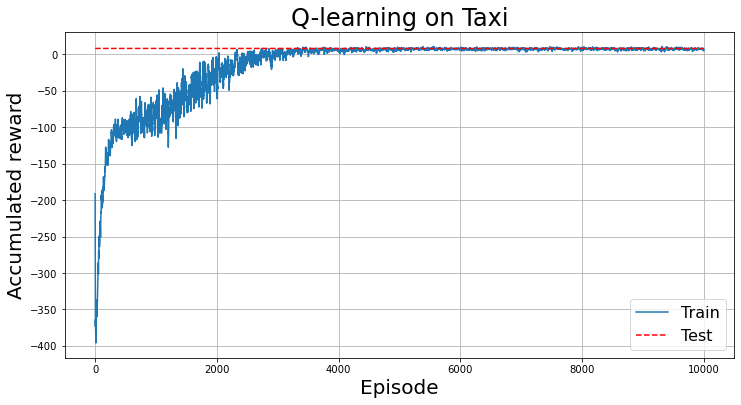

In [9]:
plot_data(reward_train, reward_test, x_axis = 'Episode' , y_axis = 'Accumulated reward' , smoothing=True, window=10)

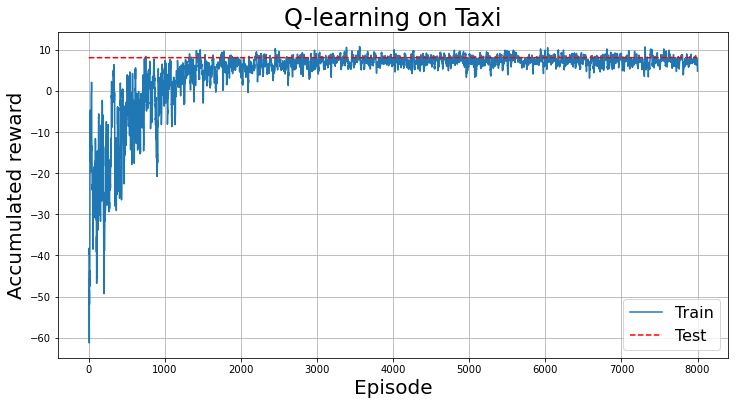

In [10]:
plot_data(reward_train[2000:], reward_test, x_axis = 'Episode' , y_axis = 'Accumulated reward' , smoothing=True, window=10)

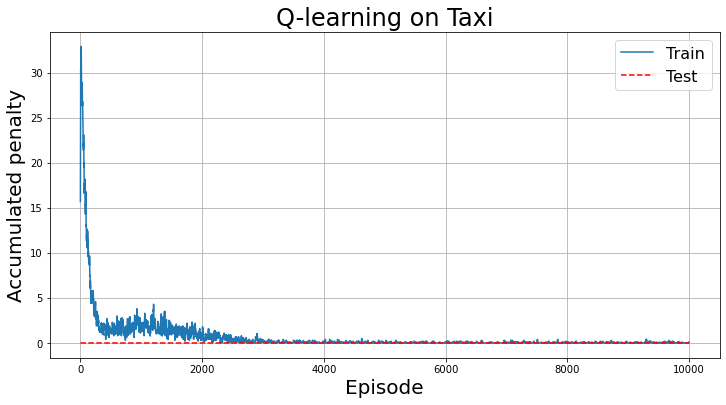

In [11]:
plot_data(penalty_train, penalty_test, x_axis = 'Episode' , y_axis = 'Accumulated penalty' , smoothing=True, window=10)

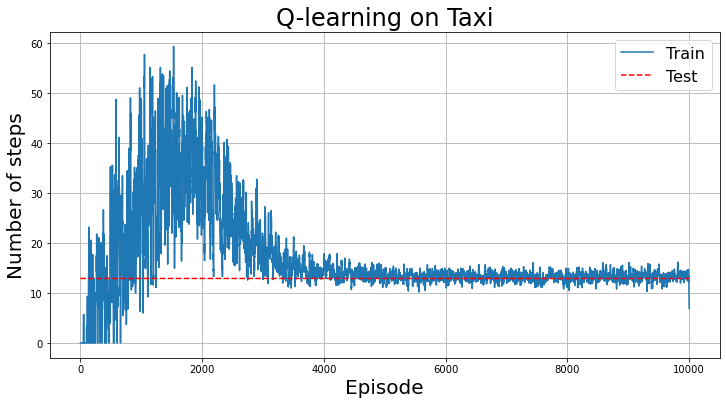

In [12]:
plot_data(steps_train, steps_test, x_axis = 'Episode' , y_axis = 'Number of steps' , smoothing=True, window=10)

In [13]:
print_frames(frames[21])

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 17
State: 85
Action: 5
Reward: 20


In [14]:
print(agent.epsilon)

0.01


In [15]:
env.close()